In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=c7bca99af87f5363705551001af70c06bcac71dc241251a291a54cb85bfa7071
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e7c68ddd92cac8246b3cc410fd916f5232c1f0d0a8c0a8d6212fadaa7b730023
  Stored in directory: /root/.cache/pip/w

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dowload Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 49.91 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


## Import Libraries

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Setup Configuration

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255



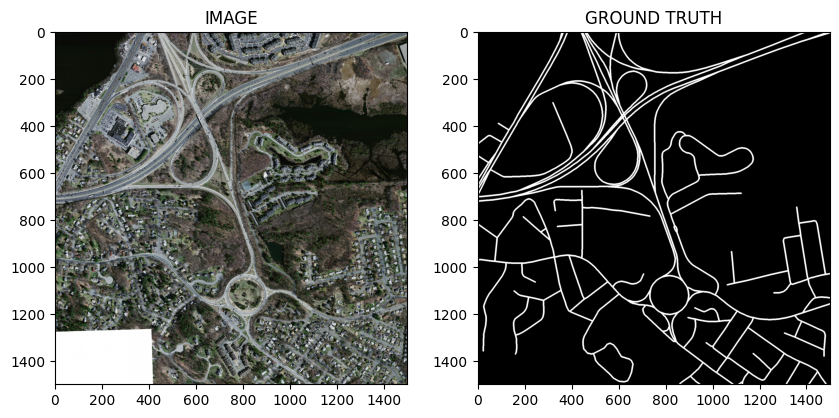

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap='gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [ ]:
len(valid_df)

40

In [ ]:
len(train_df)

159

## Augmentation Functions

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
    return A.Compose([
          A.Resize(IMG_SIZE, IMG_SIZE),
          A.HorizontalFlip(p = 0.5),
          A.VerticalFlip(p = 0.5),
    ])

In [ ]:
def get_valid_augs():
    return A.Compose([
          A.Resize(IMG_SIZE, IMG_SIZE),
    ])

## Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

      def __init__(self,df,augmentations):
          self.df = df
          self.augmentations = augmentations

      def __len__(self):
          return len(self.df)

      def __getitem__(self, idx):
          row = self.df.iloc[idx]

          image_path = DATA_DIR + row.images
          mask_path = DATA_DIR + row.masks

          image = cv2.imread(image_path)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (h,w,c)

          mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
          mask = np.expand_dims(mask, axis = -1) # (h, w, c)

          if self.augmentations:
              data = self.augmentations(image = image, mask = mask)
              image = data['image'] # (h, w, c)
              mask = data['mask']

          image = np.transpose(image, (2,0,1)).astype(np.float32) # (c, h, w)
          mask = np.transpose(mask, (2,0,1)).astype(np.float32) # (c, h, w)

          image = torch.Tensor(image) / 255.0
          mask = torch.round(torch.Tensor(mask) / 255.0)

          return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


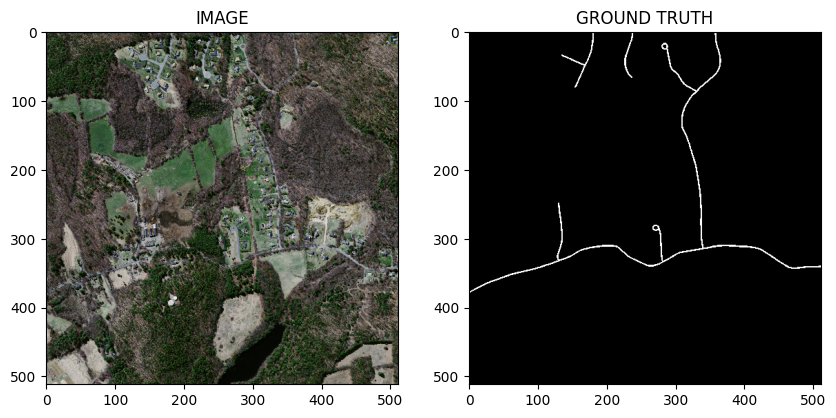

In [ ]:
idx = 3

image, mask = trainset[idx]

helper.show_image(image, mask)

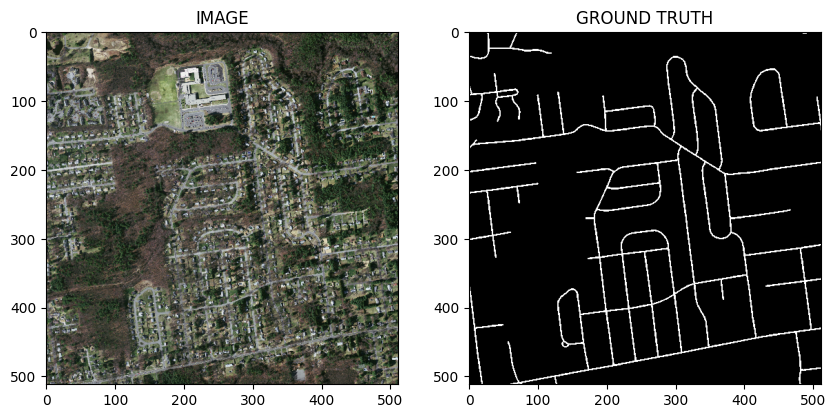

In [ ]:
idx = 20

image, mask = validset[idx]

helper.show_image(image, mask)

## Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE, shuffle = False)

In [ ]:
print(f'Total no. of batches in trainloader: {len(trainloader)}')
print(f'Total no. of batches in validloader: {len(validloader)}')

Total no. of batches in trainloader: 20
Total no. of batches in validloader: 5


In [ ]:
for images, masks in trainloader:

    print(f'One batch image shape: {images.shape}')
    print(f'One batch mask shape: {masks.shape}')
    break

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


## Create Segmentation Model

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

      def __init__(self):
          super(SegmentationModel, self).__init__()

          self.backbone = smp.Unet(
              encoder_name = ENCODER,
              encoder_weights = WEIGHTS,
              in_channels=3,
              classes = 1,
              activation = None
          )

      def forward(self, images, masks = None):

          logits = self.backbone(images)

          if masks != None:
              return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

          return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

## Create Train and Validation Function

In [ ]:
def train_fn(dataloader,model,optimizer):

    model.train() # Turn ON dropout, batchnorm, etc ...
    total_loss = 0.0

    for images, masks in tqdm(dataloader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def eval_fn(dataloader,model):

    model.eval() # Turn OFF dropout
    total_loss = 0.0

    with torch.no_grad():

        for images, masks in tqdm(dataloader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

        return total_loss / len(dataloader)

## Train model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_loss:
        torch.save(model.state_dict(),'best-model.pt')
        print('SAVED-MODEL')
        best_loss = valid_loss

    print(f'Epoch: {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}')

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch: 1 Train Loss: 0.8412855714559555 Valid Loss: 0.9639117360115051


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


SAVED-MODEL
Epoch: 2 Train Loss: 0.7338300198316574 Valid Loss: 0.7654658794403076


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED-MODEL
Epoch: 3 Train Loss: 0.6810952842235565 Valid Loss: 0.7229757666587829


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


SAVED-MODEL
Epoch: 4 Train Loss: 0.664042842388153 Valid Loss: 0.7005752801895142


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


SAVED-MODEL
Epoch: 5 Train Loss: 0.6501534909009934 Valid Loss: 0.6925177693367004


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch: 6 Train Loss: 0.6342055290937424 Valid Loss: 0.6932760596275329


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 7 Train Loss: 0.6431928306818009 Valid Loss: 0.7067605376243591


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch: 8 Train Loss: 0.6182217091321945 Valid Loss: 0.6705364465713501


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 9 Train Loss: 0.6184693962335587 Valid Loss: 0.6778395771980286


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


SAVED-MODEL
Epoch: 10 Train Loss: 0.6092482924461364 Valid Loss: 0.6562387347221375


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch: 11 Train Loss: 0.6015246540307999 Valid Loss: 0.6785293579101562


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


SAVED-MODEL
Epoch: 12 Train Loss: 0.6128736793994903 Valid Loss: 0.6478368401527405


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


SAVED-MODEL
Epoch: 13 Train Loss: 0.6060580924153328 Valid Loss: 0.6213519215583801


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch: 14 Train Loss: 0.5933869004249572 Valid Loss: 0.651219618320465


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch: 15 Train Loss: 0.5907204777002335 Valid Loss: 0.6352404356002808


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch: 16 Train Loss: 0.5887392640113831 Valid Loss: 0.6605895638465882


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


SAVED-MODEL
Epoch: 17 Train Loss: 0.5843653857707978 Valid Loss: 0.6193875551223755


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


SAVED-MODEL
Epoch: 18 Train Loss: 0.5724400222301483 Valid Loss: 0.6067381978034974


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 19 Train Loss: 0.5859986424446106 Valid Loss: 0.6348369717597961


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 20 Train Loss: 0.5707006394863129 Valid Loss: 0.6339805126190186


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 21 Train Loss: 0.5608425512909889 Valid Loss: 0.6488509058952332


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch: 22 Train Loss: 0.5580078482627868 Valid Loss: 0.6211778402328492


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 23 Train Loss: 0.5515424594283104 Valid Loss: 0.6207936644554138


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch: 24 Train Loss: 0.5704797193408012 Valid Loss: 0.6419318914413452


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

Epoch: 25 Train Loss: 0.5598408073186875 Valid Loss: 0.6529253005981446


## Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h , w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

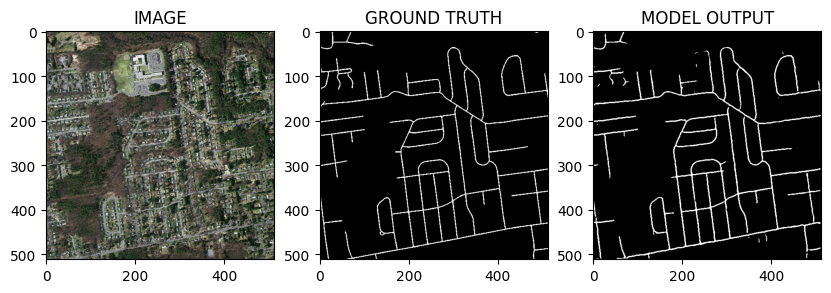

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))